# Part a: Loading data, and prepare it for machine learning

When thinking about data analysis, the first things comes to my mind is NBA stats. I am a die hard NBA fan, and using python to analyze these data seems to be a great match.

In [ ]:
from google.colab import files

upload = files.upload()

Saving MVP_Players.csv to MVP_Players.csv


The dataset is from https://www.basketball-reference.com/. Before importing it to the csv file, we add some new columns: win rate and mvp rating. Mvp rating is manually entered by referencing https://ak-static.cms.nba.com/wp-content/uploads/sites/46/2024/05/2023-24-Kia-NBA-MVP-Voting-Results.pdf


The csv we grab is the MVP Voting players, sorted by their points per game:

In [ ]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('MVP_Players.csv') # I grab this csv from nbastat.com, and I modify the csv to make it display the information we want.
df = df.drop(columns=['Awards'])
df['MVP Voting']= df['MVP Voting'] / 990 # to calculate MVP share, the total vote for one season is 990.
df.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Win Rate,MVP Voting
0,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,0.487,...,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,0.657,0.561616
1,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,0.611,...,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4,0.598,0.193939
2,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,0.535,...,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1,0.695,0.646465
3,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,0.479,...,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7,0.573,0.143434
4,Kevin Durant,35,PHO,PF,75,75,37.2,10.0,19.1,0.523,...,6.1,6.6,5.0,0.9,1.2,3.3,1.8,27.1,0.549,0.001010


In [ ]:
df = df.head(10)
pd.set_option('display.max_rows', 10) # to take a look of the dataset
print(df.head(10))

                    Player  Age Team Pos   G  GS    MP    FG   FGA    FG%  \
0              Luka Dončić   24  DAL  PG  70  70  37.5  11.5  23.6  0.487   
1    Giannis Antetokounmpo   29  MIL  PF  73  73  35.2  11.5  18.8  0.611   
2  Shai Gilgeous-Alexander   25  OKC  PG  75  75  34.0  10.6  19.8  0.535   
3            Jalen Brunson   27  NYK  PG  77  77  35.4  10.3  21.4  0.479   
4             Kevin Durant   35  PHO  PF  75  75  37.2  10.0  19.1  0.523   
5             Jayson Tatum   25  BOS  PF  74  74  35.7   9.1  19.3  0.471   
6             Nikola Jokić   28  DEN   C  79  79  34.6  10.4  17.9  0.583   
7          Anthony Edwards   22  MIN  SG  79  78  35.1   9.1  19.7  0.461   
8         Domantas Sabonis   27  SAC   C  82  82  35.7   7.7  13.8  0.594   

   ...   DRB   TRB  AST  STL  BLK  TOV   PF   PTS  Win Rate  MVP Voting  
0  ...   8.4   9.2  9.8  1.4  0.5  4.0  2.1  33.9     0.657    0.561616  
1  ...   8.8  11.5  6.5  1.2  1.1  3.4  2.9  30.4     0.598    0.193939  
2  ... 

What are the factors that contribute most to the mvp voting? We can have a rough view of that by using Random Forests. But, We may want to check the types of the data, first.

In [ ]:
df.dtypes

,0
Player,object
Age,int64
Team,object
Pos,object
G,int64
...,...
TOV,float64
PF,float64
PTS,float64
Win Rate,float64


Looks great. However, would it be feasiable for us to analyze all the categories in the table? Maybe not. Intuitively, this is not going to work as we have too much variables and it would be hard for our models generalize the result. Therefore, we should prosecute the raw data at first.

 We may want to add some extra columns: PTS per 36 minutes, the TS% (Ture Shooting Percentage), PER.

PTS per 36 minutes is simple: we can calcuate them from our existing columns.

In [ ]:
df['PTS per 36 Min'] = df['PTS'] / df['MP'] * 36
df.head(10)

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,Win Rate,MVP Voting,PTS per 36 Min
0,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,0.487,...,9.2,9.8,1.4,0.5,4.0,2.1,33.9,0.657,0.561616,32.544000
1,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,0.611,...,11.5,6.5,1.2,1.1,3.4,2.9,30.4,0.598,0.193939,31.090909
2,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,0.535,...,5.5,6.2,2.0,0.9,2.2,2.5,30.1,0.695,0.646465,31.870588
3,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,0.479,...,3.6,6.7,0.9,0.2,2.4,1.9,28.7,0.573,0.143434,29.186441
4,Kevin Durant,35,PHO,PF,75,75,37.2,10.0,19.1,0.523,...,6.6,5.0,0.9,1.2,3.3,1.8,27.1,0.549,0.001010,26.225806
5,Jayson Tatum,25,BOS,PF,74,74,35.7,9.1,19.3,0.471,...,8.1,4.9,1.0,0.6,2.5,2.0,26.9,0.707,0.086869,27.126050
6,Nikola Jokić,28,DEN,C,79,79,34.6,10.4,17.9,0.583,...,12.4,9.0,1.4,0.9,3.0,2.5,26.4,0.671,0.935354,27.468208
7,Anthony Edwards,22,MIN,SG,79,78,35.1,9.1,19.7,0.461,...,5.4,5.1,1.3,0.5,3.1,1.8,25.9,0.610,0.018182,26.564103
8,Domantas Sabonis,27,SAC,C,82,82,35.7,7.7,13.8,0.594,...,13.7,8.2,0.9,0.6,3.3,3.0,19.4,0.585,0.003030,19.563025


TS% is a relatively tricky one. It follows the formula:

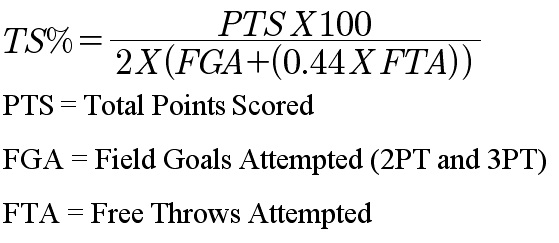

In [ ]:
df['TS%'] = df['PTS'] * 100 / (2 * (df['FGA'] + 0.44 * df['FTA']))
df.head(10)

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Win Rate,MVP Voting,PTS per 36 Min,TS%
0,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,0.487,...,9.8,1.4,0.5,4.0,2.1,33.9,0.657,0.561616,32.544000,61.798162
1,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,0.611,...,6.5,1.2,1.1,3.4,2.9,30.4,0.598,0.193939,31.090909,64.658840
2,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,0.535,...,6.2,2.0,0.9,2.2,2.5,30.1,0.695,0.646465,31.870588,63.695615
3,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,0.479,...,6.7,0.9,0.2,2.4,1.9,28.7,0.573,0.143434,29.186441,59.150866
4,Kevin Durant,35,PHO,PF,75,75,37.2,10.0,19.1,0.523,...,5.0,0.9,1.2,3.3,1.8,27.1,0.549,0.001010,26.225806,62.836208
5,Jayson Tatum,25,BOS,PF,74,74,35.7,9.1,19.3,0.471,...,4.9,1.0,0.6,2.5,2.0,26.9,0.707,0.086869,27.126050,60.454872
6,Nikola Jokić,28,DEN,C,79,79,34.6,10.4,17.9,0.583,...,9.0,1.4,0.9,3.0,2.5,26.4,0.671,0.935354,27.468208,64.960630
7,Anthony Edwards,22,MIN,SG,79,78,35.1,9.1,19.7,0.461,...,5.1,1.3,0.5,3.1,1.8,25.9,0.610,0.018182,26.564103,57.514656
8,Domantas Sabonis,27,SAC,C,82,82,35.7,7.7,13.8,0.594,...,8.2,0.9,0.6,3.3,3.0,19.4,0.585,0.003030,19.563025,60.458738


Box Plus-Minus (BPM) is an advanced statistic in NBA analytics that estimates a player’s overall impact on a team per 100 possessions while they’re on the floor. It takes into account both offensive and defensive contributions, making it a valuable tool for understanding a player’s influence beyond just points scored or rebounds grabbed.

* First, it requires the data from every player and every team, it is not feasiable for us to do that in this project.
* Second, the *factor* of the model varies in different NBA stats model. The image below is only one of them.

https://www.basketball-reference.com/about/bpm2.html
BPM=1.15×Points+0.85×Assists+0.75×Rebounds−1.00×Turnovers+Team Adjustment+Position Adjustment


Therefore, here, we may choose to directly use the calcuated PER from StatMuse, instead of using our own.

In [ ]:
bpm_values = [9.8, 8.5, 9.2, 5.4, 6.7, 6.1, 13.0, 4.2, 5.4] # data from StatMuse
df['BPM'] = bpm_values

In [ ]:
df.head(10)

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,STL,BLK,TOV,PF,PTS,Win Rate,MVP Voting,PTS per 36 Min,TS%,BPM
0,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,0.487,...,1.4,0.5,4.0,2.1,33.9,0.657,0.561616,32.544000,61.798162,9.8
1,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,0.611,...,1.2,1.1,3.4,2.9,30.4,0.598,0.193939,31.090909,64.658840,8.5
2,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,0.535,...,2.0,0.9,2.2,2.5,30.1,0.695,0.646465,31.870588,63.695615,9.2
3,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,0.479,...,0.9,0.2,2.4,1.9,28.7,0.573,0.143434,29.186441,59.150866,5.4
4,Kevin Durant,35,PHO,PF,75,75,37.2,10.0,19.1,0.523,...,0.9,1.2,3.3,1.8,27.1,0.549,0.001010,26.225806,62.836208,6.7
5,Jayson Tatum,25,BOS,PF,74,74,35.7,9.1,19.3,0.471,...,1.0,0.6,2.5,2.0,26.9,0.707,0.086869,27.126050,60.454872,6.1
6,Nikola Jokić,28,DEN,C,79,79,34.6,10.4,17.9,0.583,...,1.4,0.9,3.0,2.5,26.4,0.671,0.935354,27.468208,64.960630,13.0
7,Anthony Edwards,22,MIN,SG,79,78,35.1,9.1,19.7,0.461,...,1.3,0.5,3.1,1.8,25.9,0.610,0.018182,26.564103,57.514656,4.2
8,Domantas Sabonis,27,SAC,C,82,82,35.7,7.7,13.8,0.594,...,0.9,0.6,3.3,3.0,19.4,0.585,0.003030,19.563025,60.458738,5.4


Now, we can clean our dataframe in the following columns:

* Player
* Team
* PTS per 36 Min
* TS%
* BPM
* Win Rate
* MVP Voting

The features we want are probably: PTS per 36 min, TS%, PER, and Win rate. These four features may provide us a good look for mvp voting.

In [ ]:
df_advanced = df.loc[:, ['Player', 'Team', 'PTS per 36 Min', 'TS%', 'BPM', 'Win Rate', 'MVP Voting']]
df_advanced.head(10)

,Player,Team,PTS per 36 Min,TS%,BPM,Win Rate,MVP Voting
0,Luka Dončić,DAL,32.544000,61.798162,9.8,0.657,0.561616
1,Giannis Antetokounmpo,MIL,31.090909,64.658840,8.5,0.598,0.193939
2,Shai Gilgeous-Alexander,OKC,31.870588,63.695615,9.2,0.695,0.646465
3,Jalen Brunson,NYK,29.186441,59.150866,5.4,0.573,0.143434
4,Kevin Durant,PHO,26.225806,62.836208,6.7,0.549,0.001010
5,Jayson Tatum,BOS,27.126050,60.454872,6.1,0.707,0.086869
6,Nikola Jokić,DEN,27.468208,64.960630,13.0,0.671,0.935354
7,Anthony Edwards,MIN,26.564103,57.514656,4.2,0.610,0.018182
8,Domantas Sabonis,SAC,19.563025,60.458738,5.4,0.585,0.003030


In [ ]:
df_advanced.describe()

,PTS per 36 Min,TS%,BPM,Win Rate,MVP Voting
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,27.959903,61.725399,7.588889,0.627222,0.287767
std,3.937242,2.543865,2.776439,0.056738,0.340772
min,19.563025,57.514656,4.200000,0.549000,0.001010
25%,26.564103,60.454872,5.400000,0.585000,0.018182
50%,27.468208,61.798162,6.700000,0.610000,0.143434
75%,31.090909,63.695615,9.200000,0.671000,0.561616
max,32.544000,64.960630,13.000000,0.707000,0.935354


# Part b: Predicting target variables using RandomForestClassifier

We should have more datapoints, 9 is a very small number. Therefore, I do the same column operations to obtain the new csv: 50 Mvps:

In [ ]:
from google.colab import files


upload = files.upload()

Saving MVPs.csv to MVPs.csv


In [ ]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df_advanced = pd.read_csv('MVPs.csv',encoding='ISO-8859-1')
df_advanced['TS%'] = df_advanced['TS%'].str.rstrip('%').astype(float) / 100 # convert TS% to float numbers
df_advanced.head(10)

,Player,Team,PTS/36,TS%,BPM,Win Rate,MVP Voting Share,Year
0,Giannis Antetokounmpo,MIL,28.2,0.644,10.8,0.732,0.776,2018-19
1,James Harden,HOU,36.3,0.616,11.0,0.646,0.676,2018-19
2,Paul George,OKC,28.6,0.580,5.7,0.598,0.145,2018-19
3,Nikola Joki?,DEN,23.0,0.585,9.1,0.659,0.041,2018-19
4,Stephen Curry,GSW,28.3,0.640,8.4,0.695,0.037,2018-19
5,Damian Lillard,POR,27.8,0.594,6.3,0.598,0.020,2018-19
6,Joel Embiid,PHI,28.3,0.593,5.0,0.622,0.010,2018-19
7,Kevin Durant,GSW,26.5,0.631,6.5,0.695,0.005,2018-19
8,Kawhi Leonard,TOR,27.9,0.606,5.0,0.707,0.005,2018-19
9,Giannis Antetokounmpo,MIL,31.6,0.613,11.5,0.767,0.856,2019-20


Since the mvp voting we want to predict is a value instead of a categorical data, the random forest would not be feasiable. If we want to do a random forest, we should covert the votings into a rank, then convert the ranks into categories, like:

* The top 5 in the 50s is considered "Top MVP Candidate"
* 6-20 could be "High MVP Contender"
* 21-35 could be "Moderate MVP contender"
* 36+ could be "Low MVP Contender".

In [ ]:
df_advanced2 = df_advanced.sort_values(by='MVP Voting Share', ascending=False).reset_index(drop=True)

# Define the function to categorize MVP contenders based on sorted index
def categorize_by_rank(index):
    if index < 5:
        return "Top MVP Candidate"
    elif index < 20:
        return "High MVP Contender"
    elif index < 35:
        return "Moderate MVP Contender"
    else:
        return "Low MVP Contender"

df_advanced2['MVP_Category'] = df_advanced.index.map(categorize_by_rank)

df_advanced2.head(10)

,Player,Team,PTS/36,TS%,BPM,Win Rate,MVP Voting Share,Year,MVP_Category
0,Nikola Joki?,DEN,26.8,0.647,11.7,0.653,0.971,2020-21,Top MVP Candidate
1,Nikola Joki?,DEN,27.5,0.650,13.0,0.671,0.935,2023-24,Top MVP Candidate
2,Joel Embiid,PHI,34.0,0.655,9.2,0.646,0.924,2022-23,Top MVP Candidate
3,Nikola Joki?,DEN,27.5,0.661,13.7,0.585,0.875,2021-22,Top MVP Candidate
4,Giannis Antetokounmpo,MIL,31.6,0.613,11.5,0.767,0.856,2019-20,Top MVP Candidate
5,Giannis Antetokounmpo,MIL,28.2,0.644,10.8,0.732,0.776,2018-19,High MVP Contender
6,LeBron James,LAL,25.5,0.586,8.9,0.732,0.753,2019-20,High MVP Contender
7,Joel Embiid,PHI,31.0,0.616,7.5,0.622,0.706,2021-22,High MVP Contender
8,James Harden,HOU,36.3,0.616,11.0,0.646,0.676,2018-19,High MVP Contender
9,Nikola Joki?,DEN,24.5,0.701,12.2,0.659,0.674,2022-23,High MVP Contender


In [ ]:
X = df_advanced2[["PTS/36", "TS%", "BPM", "Win Rate"]]
y1 = df_advanced2['MVP_Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.1, random_state=2024)

mvpforest = RandomForestClassifier(n_estimators=200,random_state=2024)
mvpforest.fit(X_train, y_train)
accuracy = mvpforest.score(X_test, y_test)

print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.8333333333333334


Choose one argument to RandomForestClassifier besides n_estimators that we vary to try to improve our classifier's accuracy. (See documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Train three different classifiers with different values for this parameter, counting the one you already trained.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# do a set of cross_val_score
mvpforest = RandomForestClassifier(n_estimators=200, random_state=2024)

cv_scores = cross_val_score(mvpforest, X, y1, cv=5)

print("Cross-validation scores for each fold:", cv_scores)
print("Average cross-validation accuracy:", cv_scores.mean())

Cross-validation scores for each fold: [0.5        0.66666667 0.75       0.75       0.58333333]
Average cross-validation accuracy: 0.65


In [ ]:
# Trail 2:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=2024)

mvpforest2 = RandomForestClassifier(n_estimators=500,max_depth=10, random_state=2024)
mvpforest2.fit(X_train, y_train)
accuracy = mvpforest2.score(X_test, y_test)

print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.75


In [ ]:
# Trail 3
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=2024)

mvpforest3 = RandomForestClassifier(n_estimators=500,max_depth=10, max_features='sqrt', random_state=2024)
mvpforest3.fit(X_train, y_train)

mvpforest3.fit(X_train, y_train)
accuracy = mvpforest3.score(X_test, y_test)

print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.75


Use the _feature_importances attribute of the RandomForestClassifier to find the relative importances of all our features in our best model.

In [ ]:
mvpforest.feature_importances_

array([0.31083176, 0.20515832, 0.31665485, 0.16735507])

In our small sample size, points per 36 minutes and BPM are the most important features to decide who is the mvp: that may be true as nowadays scoring is one of the most important stats to determine a player's value (Both pts and bpm is a measurement of that).

# Part e: Perform some additional analysis

As we saw in the previous section, the dataset is not working well for the random forest. How about linear regression models? Let's have a try.

In [ ]:
df_advanced.head(10) # use the original df_advanced with all the features we want to have.

,Player,Team,PTS/36,TS%,BPM,Win Rate,MVP Voting Share,Year
0,Giannis Antetokounmpo,MIL,28.2,0.644,10.8,0.732,0.776,2018-19
1,James Harden,HOU,36.3,0.616,11.0,0.646,0.676,2018-19
2,Paul George,OKC,28.6,0.580,5.7,0.598,0.145,2018-19
3,Nikola Joki?,DEN,23.0,0.585,9.1,0.659,0.041,2018-19
4,Stephen Curry,GSW,28.3,0.640,8.4,0.695,0.037,2018-19
5,Damian Lillard,POR,27.8,0.594,6.3,0.598,0.020,2018-19
6,Joel Embiid,PHI,28.3,0.593,5.0,0.622,0.010,2018-19
7,Kevin Durant,GSW,26.5,0.631,6.5,0.695,0.005,2018-19
8,Kawhi Leonard,TOR,27.9,0.606,5.0,0.707,0.005,2018-19
9,Giannis Antetokounmpo,MIL,31.6,0.613,11.5,0.767,0.856,2019-20


In [ ]:
X2 = df_advanced[["PTS/36", "TS%", "BPM", "Win Rate"]]
y2 = df_advanced['MVP Voting Share']
linear_model = LinearRegression()
linear_model.fit(X2, y2)

y_pred = linear_model.predict(X2)

# Display results
print("Actual MVP Voting Score:", y2)
print("Predicted MVP Voting Score:", y_pred)
print("Model Coefficients:", linear_model.coef_)
print("Intercept:", linear_model.intercept_)

Actual MVP Voting Score: 0     0.776
1     0.676
2     0.145
3     0.041
4     0.037
5     0.020
6     0.010
7     0.005
8     0.005
9     0.856
10    0.753
11    0.367
12    0.163
13    0.135
14    0.093
15    0.087
16    0.043
17    0.015
18    0.010
19    0.005
20    0.971
21    0.586
22    0.453
23    0.348
24    0.139
25    0.117
26    0.087
27    0.020
28    0.010
29    0.875
30    0.706
31    0.595
32    0.224
33    0.146
34    0.061
35    0.046
36    0.040
37    0.021
38    0.015
39    0.010
40    0.003
41    0.924
42    0.674
43    0.606
44    0.280
45    0.046
46    0.015
47    0.010
48    0.005
49    0.003
50    0.002
51    0.562
52    0.646
53    0.194
54    0.935
55    0.143
56    0.001
57    0.087
58    0.018
59    0.003
Name: MVP Voting Share, dtype: float64
Predicted MVP Voting Score: [ 0.68279589  0.697444    0.12198985  0.45489506  0.42940556  0.17077813
  0.06651822  0.23970343  0.11982605  0.80257002  0.50112498  0.31790165
  0.31034206  0.22024761  0.29183673  0.13

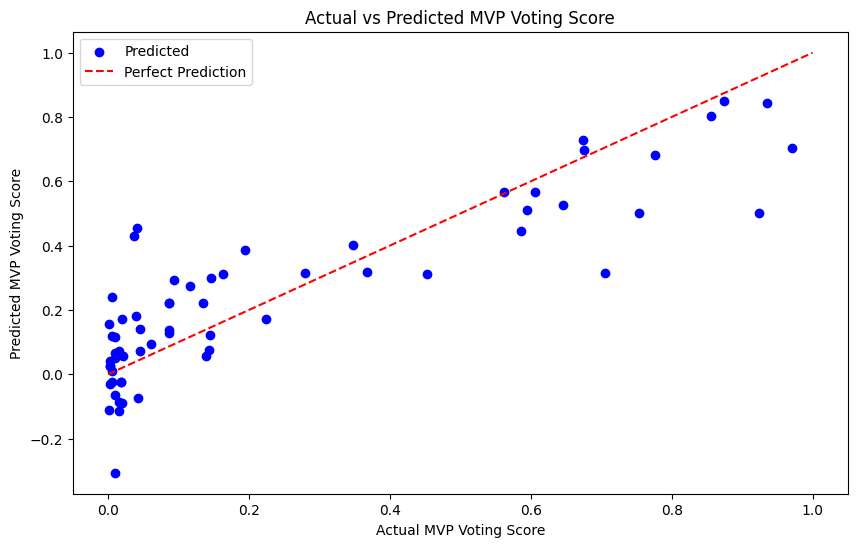

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#data from our result in the last cell, I copy and paste them here...
actual_scores = np.array([
    0.971, 0.935, 0.924, 0.875, 0.856, 0.776, 0.753, 0.706, 0.676, 0.674,
    0.646, 0.606, 0.595, 0.586, 0.562, 0.453, 0.367, 0.348, 0.280, 0.224,
    0.194, 0.163, 0.146, 0.145, 0.143, 0.139, 0.135, 0.117, 0.093, 0.087,
    0.087, 0.087, 0.061, 0.046, 0.046, 0.043, 0.041, 0.040, 0.037, 0.021,
    0.020, 0.020, 0.018, 0.015, 0.015, 0.015, 0.010, 0.010, 0.010, 0.010,
    0.010, 0.005, 0.005, 0.005, 0.005, 0.003, 0.003, 0.003, 0.002, 0.001,
    0.087, 0.018, 0.003
])
predicted_scores = np.array([
    0.70466941, 0.84472582, 0.50127166, 0.84870184, 0.80257002, 0.68279589,
    0.50112498, 0.31504513, 0.697444, 0.72833387, 0.52790846, 0.56833098,
    0.51230992, 0.44623705, 0.56747906, 0.31192494, 0.31790165, 0.40303793,
    0.3144007, 0.17289748, 0.38601508, 0.31034206, 0.29804091, 0.12198985,
    0.07618737, 0.0568071, 0.22024761, 0.27495917, 0.29183673, 0.12735743,
    0.22046952, 0.13755288, 0.09465685, 0.07392485, 0.14015714, -0.07346144,
    0.45489506, 0.18239931, 0.42940556, 0.05739979, -0.088244, 0.17077813,
    -0.02340731, -0.08492836, 0.07389352, -0.11481239, -0.06509762, 0.11495845,
    0.0494587, 0.06651822, -0.30612003, 0.11982605, -0.02425413, 0.23970343,
    0.00868344, -0.02898646, 0.0417604, 0.02432932, -0.11150882, 0.15615584,
    0.22046952, -0.02340731, 0.02432932
])

# Plotting actual vs predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(actual_scores, predicted_scores, color='blue', label='Predicted')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual MVP Voting Score')
plt.ylabel('Predicted MVP Voting Score')
plt.title('Actual vs Predicted MVP Voting Score')
plt.legend()
plt.show()


Our prediction is...Pretty good? Just look at the two tables we have. We can also visualize our mvp voting vs predicted voting on a bar chart graph.The following one is an example of the 23-24 season:

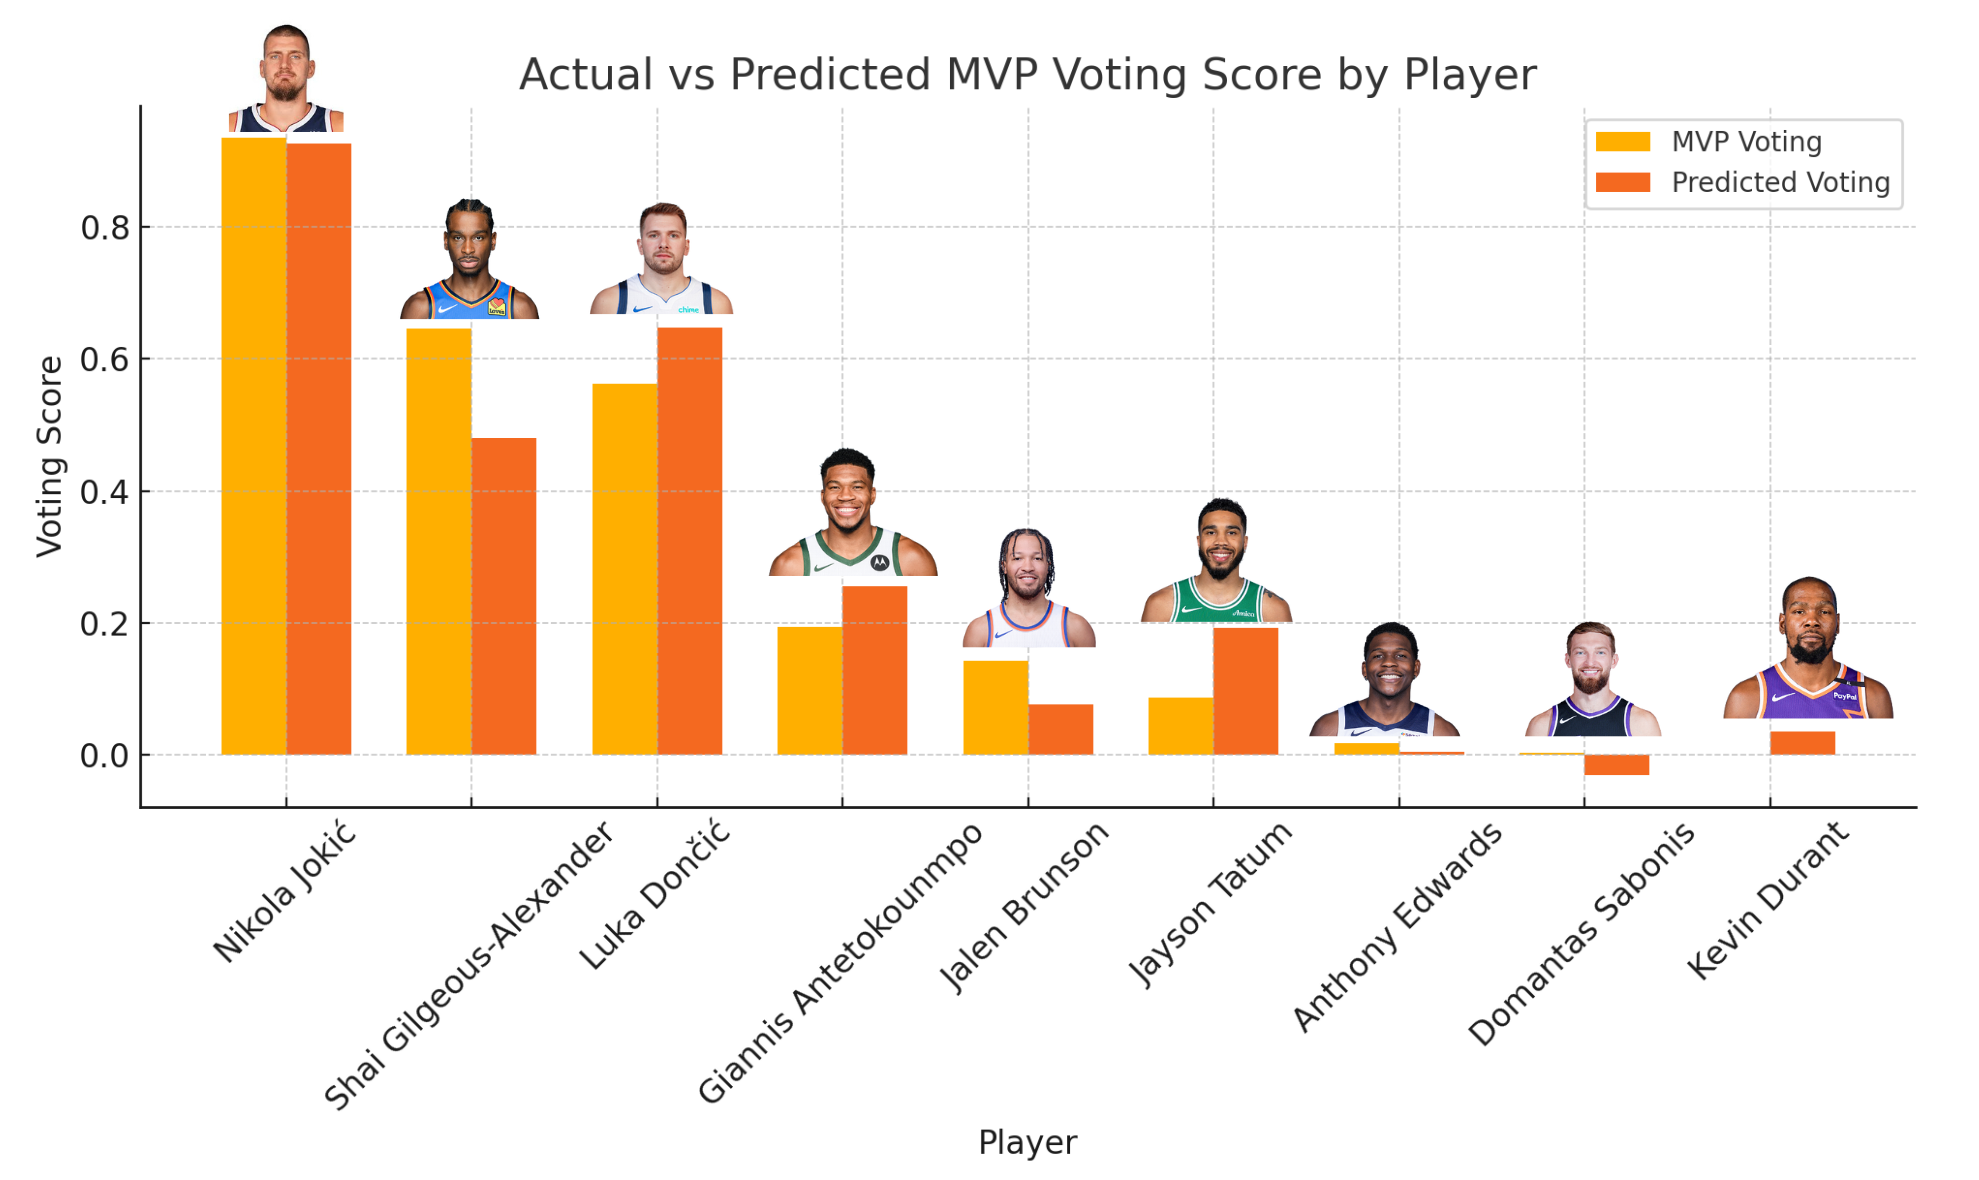

(Image created by GPT based on our data, I add the players' name and images on Canva.)
* Canva Link: https://www.canva.com/design/DAGWMqcoEgw/LGRXHawVAPErJfGNZ9JsRA/edit?utm_content=DAGWMqcoEgw&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton
* GPT Prompt: I have the dataset of all the players with their actual vote and predicted vote. Can you help me draw a bar chart for players in the 2023-24 season, from my dataset, and each player should have two bars (Actual vs Prediction)?

# Next Steps (Part f)
* What can we infer from our model?
* Should we do a prediction for other years, based on our model?

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r2 = r2_score(y2, y_pred)
print("R-squared:", r2)

R-squared: 0.7506098233414927


Our R-squared value is 0.75, which shows our prediction under small sample size has a medium accuracy. This is actually a very good result compares to a 90%+ accuracy. Why? Since the voters for mvps are experts, or humans: they may use an advanced model to check a player's performance, but they will also consider things that are not displayed on any datasets: stories on and off the court. That can be a historical performance on a particular night, that can be a player's statement in the media press, that can also just be something personal: The expert just like one player.

For the random forest we did before, it's performance was not very good, only around 65% to 83%. This is due to our relatively small sample size (60 datapoints), and the categorization (we manually set that, and it was not very accurate). But again, this also shows the fact that using a single model to predict mvp in NBA is not an easy job.

But still, it would be interesting to use our regression model to predict the mvp of this season. Currently, we only have around 10 games played for each team, so the sample size is very unrepresentative. We are just doing it for fun.

In [ ]:
from google.colab import files

upload = files.upload()

Saving 2425 mvps.csv to 2425 mvps.csv


In [ ]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

new_season_mvps = pd.read_csv('2425 mvps.csv') # I create the csv by looking up data on the NBA website
new_season_mvps.head(10)

,Player,Team,PTS/36,TS%,BPM,Team Win Rate
0,Anthony Davis,LAL,32.4,0.581,9.5,0.600
1,Jayson Tatum,BOS,28.5,0.600,7.5,0.875
2,Nikola Joki?,DEN,25.0,0.620,5.5,0.667
3,Shai Gilgeous-Alexander,OKC,27.0,0.590,6.8,0.700
4,Donovan Mitchell,CLE,24.4,0.608,6.0,1.000
5,Kevin Durant,PHX,26.5,0.610,6.5,0.857
6,Anthony Edwards,MIN,25.5,0.580,5.8,0.600
7,Luka Don?i?,DAL,30.2,0.610,8.8,0.556
8,Giannis Antetokounmpo,MIL,27.8,0.590,7.0,0.143
9,Tyrese Maxey,PHI,22.5,0.570,5.0,0.111


In [ ]:
# Model coefficients and intercept
coefficients = [0.00590382, -0.27233993, 0.09554017, 0.69658563]
intercept = -0.8500393528788966

# Calculate the predicted value based on the model
df['Predicted_Score'] = (
    coefficients[0] * df['PTS/36'] +
    coefficients[1] * df['TS%'] +
    coefficients[2] * df['BPM'] +
    coefficients[3] * df['Team Win Rate'] +
    intercept
)

df[['Player', 'Predicted_Score']].head()

,Player,Predicted_Score
0,Anthony Davis,0.508598
1,Jayson Tatum,0.480879
2,Nikola Joki?,0.118799
3,Shai Gilgeous-Alexander,0.285966
4,Donovan Mitchell,0.398258


In [ ]:
df_sorted = df.sort_values(by='Predicted_Score', ascending=False)
df_sorted.head(10)

,Player,Team,PTS/36,TS%,BPM,Team Win Rate,Predicted_Score
0,Anthony Davis,LAL,32.4,0.581,9.5,0.600,0.508598
1,Jayson Tatum,BOS,28.5,0.600,7.5,0.875,0.480879
4,Donovan Mitchell,CLE,24.4,0.608,6.0,1.000,0.398258
7,Luka Don?i?,DAL,30.2,0.610,8.8,0.556,0.390184
5,Kevin Durant,PHX,26.5,0.610,6.5,0.857,0.358270
3,Shai Gilgeous-Alexander,OKC,27.0,0.590,6.8,0.700,0.285966
12,Ja Morant,MEM,25.0,0.600,6.0,0.600,0.125345
2,Nikola Joki?,DEN,25.0,0.620,5.5,0.667,0.118799
6,Anthony Edwards,MIN,25.5,0.580,5.8,0.600,0.114635
11,LeBron James,LAL,24.0,0.570,5.0,0.600,0.032071


Our winner is: **Anthony Davis**

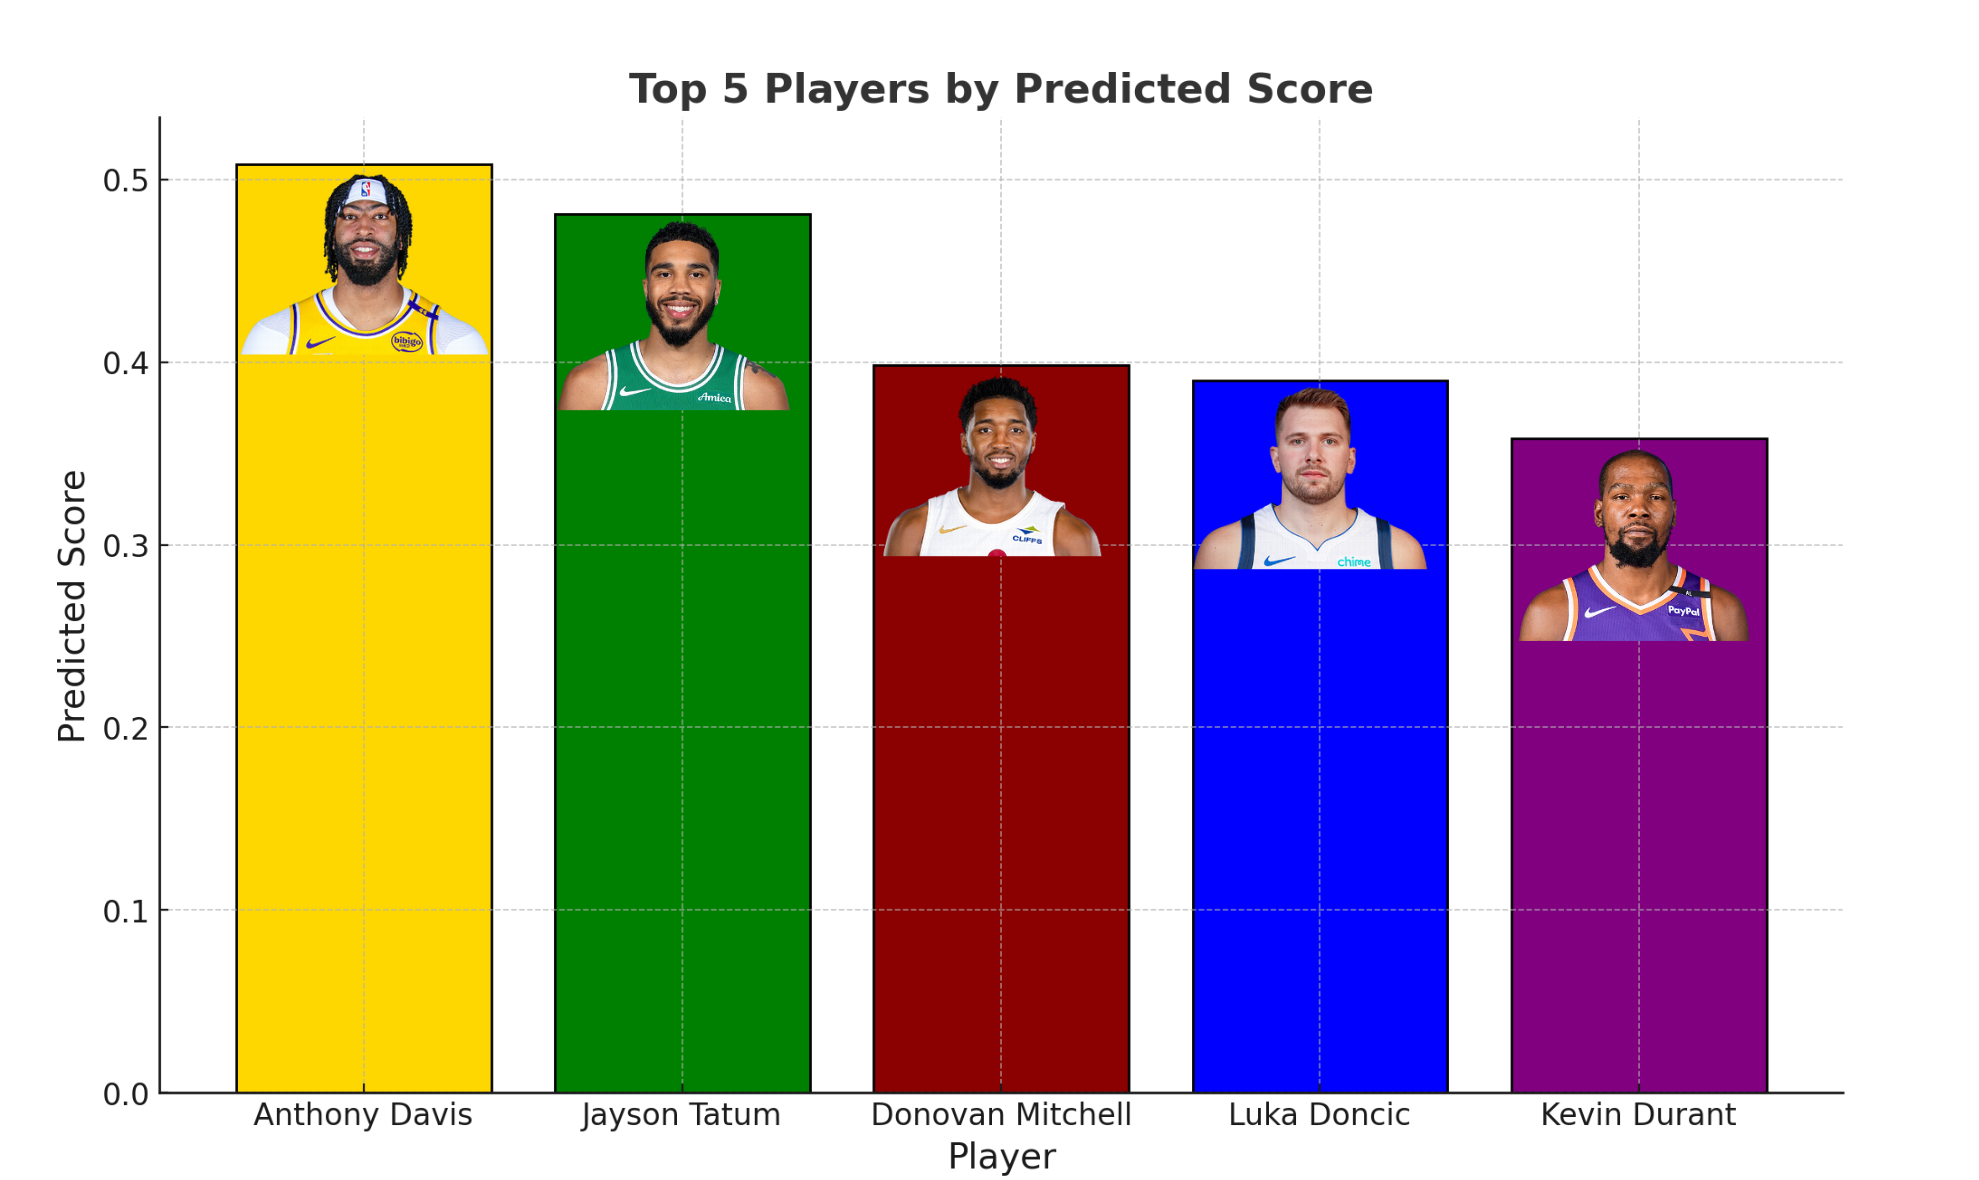

https://www.nba.com/news/kia-mvp-ladder-nov-8-2024-edition

Compares to the mvp ranking provided by nba this week, we got the winner right!

(https://www.canva.com/design/DAGWT8sa3gk/qfZbgLuV94jsGmQCTZnRvA/edit?utm_content=DAGWT8sa3gk&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton) Again, feel free to see the design for this image on Canva.